#### Oğuz Deniz 201401011
##### YAP441 Project - Monte Carlo Simulation Notebook

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [7]:
class StockMonteCarloPredictor:
    def __init__(self, num_simulations=10000):
        self.num_simulations = num_simulations
        self.scaler = StandardScaler()  # we use scaling similarly to the GARCH code if desired

    def clean_data(self, data):
        # Remove rows with NaN or infinite values
        cleaned_data = data.copy()
        cleaned_data = cleaned_data.replace([np.inf, -np.inf], np.nan)
        cleaned_data = cleaned_data.dropna()
        return cleaned_data

    def prepare_data(self, data):
        """
        Clean the data, ensure the Date column is in datetime format, set it as the index,
        calculate daily returns, and scale them.
        """
        data = self.clean_data(data)

        # Ensure Date is datetime and set as index if needed
        if 'Date' in data.columns:
            data['Date'] = pd.to_datetime(data['Date'])
            data.set_index('Date', inplace=True)

        # Calculate daily returns from the 'Adj Close' column
        data['Returns'] = data['Adj Close'].pct_change()
        data = data.dropna()

        # Optionally scale returns (here we do it to be consistent; you can skip scaling in simulation)
        returns_scaled = self.scaler.fit_transform(data['Returns'].values.reshape(-1, 1)).flatten()

        return returns_scaled, data

    def predict(self, train_returns):
        """
        Given a set of training returns, use Monte Carlo simulation to predict the direction
        for the next day. We simulate a large number of returns from a normal distribution
        with mean and standard deviation estimated from train_returns.
        
        Returns:
            - prediction (str): "Up" or "Down"
            - confidence (float): the simulated probability of the predicted direction
            - predicted_direction (int): 1 for Up, 0 for Down
        """
        # Estimate parameters from the training returns
        mu = np.mean(train_returns)
        sigma = np.std(train_returns)
        
        # Simulate next-day returns using a normal distribution with these parameters
        simulations = np.random.normal(mu, sigma, self.num_simulations)
        
        # Calculate the probability of a positive (upward) move
        prob_up = np.mean(simulations > 0)
        
        if prob_up > 0.5:
            prediction = "Up"
            predicted_direction = 1
            confidence = prob_up
        else:
            prediction = "Down"
            predicted_direction = 0
            confidence = 1 - prob_up
        
        return prediction, confidence, predicted_direction

In [8]:
def evaluate_montecarlo_predictions(data, test_size=0.2, num_simulations=10000):
    """
    Evaluate the Monte Carlo simulation approach by:
      - Preparing the data
      - For each day in the test set, using all previous returns as the training sample to
        simulate next-day returns and predict the direction.
      - Comparing the predicted direction with the actual direction.
      - Calculating accuracy and error metrics.
      - Plotting the actual vs. predicted directions.
    """
    predictor = StockMonteCarloPredictor(num_simulations=num_simulations)
    returns, df = predictor.prepare_data(data)
    
    # Determine the split index for training and testing
    split_idx = int(len(returns) * (1 - test_size))
    
    predicted_directions = []  # predictions (1 for Up, 0 for Down)
    confidences = []           # confidence levels from simulation
    actual_directions = []     # actual direction from test data
    
    # For each day in the test period, use all data prior to that day as training data.
    for i in range(split_idx, len(returns)):
        train_returns = returns[:i]
        
        # Predict next-day direction using Monte Carlo simulation
        prediction, confidence, pred_dir = predictor.predict(train_returns)
        predicted_directions.append(pred_dir)
        confidences.append(confidence)
        
        # Determine the actual direction for day i from the raw (unscaled) returns in the dataframe.
        actual_return = df.iloc[i]['Returns']
        actual_dir = 1 if actual_return > 0 else 0
        actual_directions.append(actual_dir)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(actual_directions, predicted_directions)
    mse = mean_squared_error(actual_directions, predicted_directions)
    mae = mean_absolute_error(actual_directions, predicted_directions)
    
    print("Monte Carlo Simulation Prediction Results:")
    print(f"Directional Accuracy: {accuracy:.2%}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")

    # Plot the actual vs. predicted directions for the test period as a scatter plot.
    plt.figure(figsize=(12, 6))
    test_dates = df.iloc[split_idx:].index

    # Scatter plot for actual directions
    plt.scatter(test_dates, actual_directions, label='Actual Direction', color='blue', marker='o')

    # Scatter plot for predicted directions
    plt.scatter(test_dates, predicted_directions, label='Predicted Direction', color='red', marker='x')

    plt.xlabel("Date")
    plt.ylabel("Direction (1 = Up, 0 = Down)")
    plt.title("Monte Carlo Simulation: Actual vs. Predicted Direction")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'mse': mse,
        'mae': mae,
        'predicted_directions': predicted_directions,
        'actual_directions': actual_directions,
        'confidences': confidences
    }

In [9]:
def plot_montecarlo_accuracy(results):
    """
    Plot a bar chart showing the overall directional accuracy of the Monte Carlo simulation.
    """
    accuracy = results['accuracy']
    plt.figure(figsize=(6, 4))
    plt.bar(['Monte Carlo'], [accuracy], color='lightgreen')
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.title("Monte Carlo Simulation Directional Accuracy")
    plt.text(0, accuracy + 0.02, f"{accuracy:.2%}", ha='center', fontsize=12)
    plt.show()

Monte Carlo Simulation Prediction Results:
Directional Accuracy: 52.10%
Mean Squared Error: 0.4790
Mean Absolute Error: 0.4790


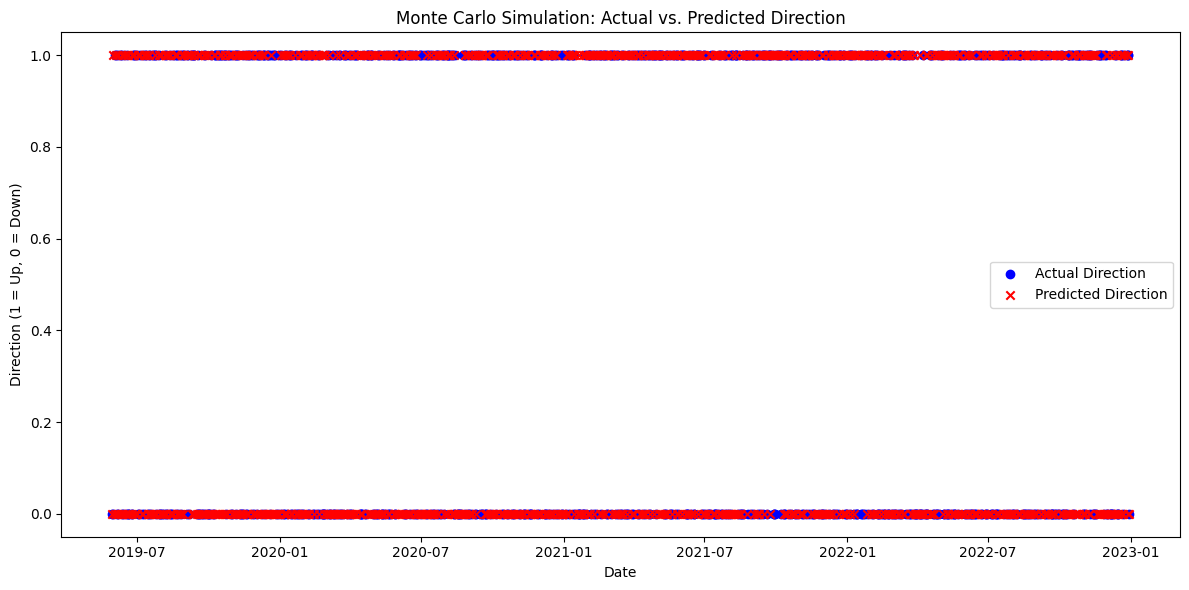

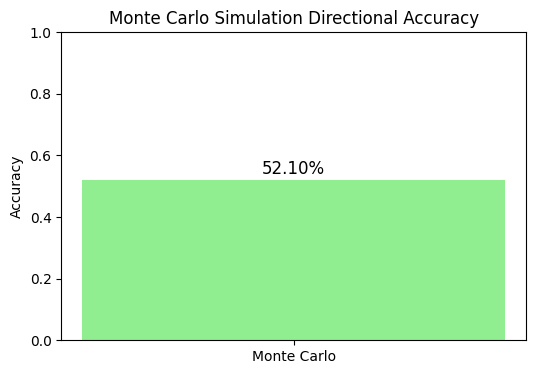

In [10]:
def main():
    try:
        # Read in the data file (make sure BAC.csv is in the working directory)
        data = pd.read_csv('BAC.csv')
        data['Date'] = pd.to_datetime(data['Date'])
        
        # Evaluate Monte Carlo predictions on the data
        montecarlo_results = evaluate_montecarlo_predictions(data, test_size=0.2, num_simulations=10000)
        
        # Plot the overall accuracy of the Monte Carlo simulation model
        plot_montecarlo_accuracy(montecarlo_results)
        
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()